<a href="https://colab.research.google.com/github/harnalashok/CatEncodersFamily/blob/main/makeblobs_pca_xgb_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset created using sklearn's `make_blobs()`


In [ ]:
# Last amended: 10th June, 2023
# Plotly plots are not showing on github when published from colab

## Basics

In [2]:
%reset -f

In [3]:
!pip install catencfamily

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.3/230.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 52.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.1/174.1 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 54.7 MB/s eta 0:00:00
  Created wheel for python-igraph: filename=python_igraph-0.10.4-py3-none-any.whl size=9073 sha256=94fba2e186df66c9b4c060699a3c58efcc8e0c11d475db54379400763f72a7a2
  Stored in directory: /root/.cache/pip/wheels/49/27/15/dcf90953e3e3322e6f3e447514b20cf39b53c6518cb4a7bace
Successfully built python-igraph


In [4]:
# 1.0 Call libraries
import pandas as pd
import numpy as np


# 1.01
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA


# 1.02
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px



# 1.03
import xgboost as xgb


# 1.04
from catencfamily.encoders import CatEncodersFamily
from catencfamily import utils

Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'bayanpy', 'graph_tool', 'infomap', 'wurlitzer'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'infomap', 'wurlitzer'}


In [5]:
# 1.05 Display multiple commands output from a cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Generate data

In [6]:
# 1.1 Generate data with sklearn's make_blobs()

X, y = make_blobs(
                   n_samples=10000,
                   n_features=6 ,
                   centers= 3,       # Dataset has three classes
                   cluster_std=1
                   )


In [7]:
# 1.2 Transform it to a DataFrame:

cols = ["c" + str(i) for i in 'abcdef']
data = pd.DataFrame(X, columns = list('abcdef'))
data['target'] = y

In [8]:
# 2.1
data.head()

,a,b,c,d,e,f,target
0,-4.451570,8.292302,0.540018,-5.695776,7.458005,-3.778900,2
1,-6.530370,-1.390835,-7.068729,-1.869853,-10.576568,-1.805815,1
2,-4.589557,5.866748,-6.089402,0.320109,7.794093,-7.841767,0
3,-5.267546,4.645434,-6.373511,1.920385,7.605972,-6.095434,0
4,-4.118762,9.343125,-1.299035,-3.302174,7.625570,-3.877123,2


In [9]:
# 2.2 Proportions of three classes:

data['target'].value_counts(normalize = True)

0    0.3334
2    0.3333
1    0.3333
Name: target, dtype: float64

In [10]:
# 2.3 Check nulls and any need for imputing?

data.isnull().sum().sum()


0

### Histogram and boxplots of features

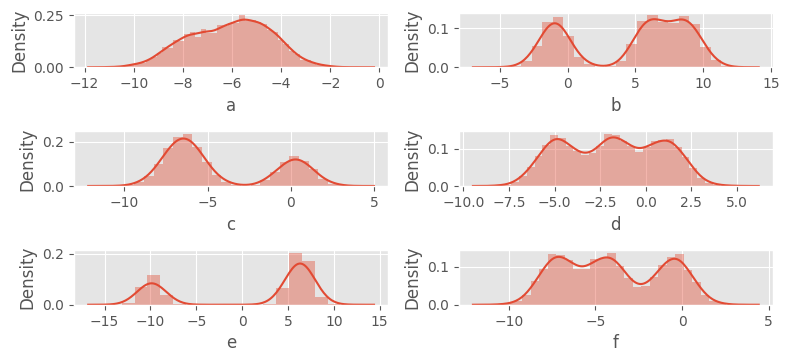

In [11]:
# 2.4 Lets look at the distribution plot of the features:
#     styles: https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html

plt.style.use("ggplot")
pos = 1
fig = plt.figure(figsize=(8,8));
for i in data.columns[:-1]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    _=sns.distplot(data[i],ax=ax);
    plt.tight_layout();

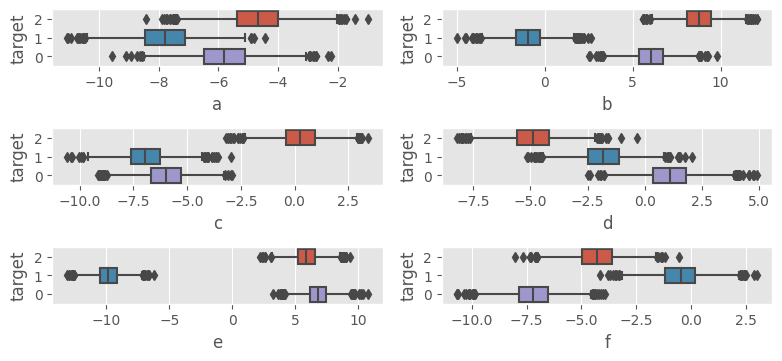

In [12]:
# 2.5 Lets look at how features are related to target:

df = data.copy()
df['target'] = df['target'].astype("string")
plt.style.use("ggplot")
pos = 1
fig = plt.figure(figsize=(8,8));
for i in df.columns[:-1]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    _=sns.boxplot(data=df, x=i, y='target')
    plt.tight_layout();

del(df)

In [13]:
# 2.5 Pop out target and check
#       proportions of classes

_= data.pop("target")

## Transform (or binning) numeric data to categorical
We transform our data as if it were categorical. (of course, such transformation is imperfect.)

To perform our experiments we bin all numeric columns to transform the data to categorical. Binning is performed using pandas `cut()` method. Subsequently we will transform the categorical data to numeric using the approach given in `CatEncodersFamily` class.  

While binning, we also split the data: both the numeric (the original) as also the binned datasets. Spliting is performed in stratified manner using `train_test_split()` function of sklearn; `target (y)` is used to stratify. While splitting, for easy comparison, we  see to it that same set of rows occur in `orig_train` and `train_binned` on the one hand and `orig_test` and `test_binned` on the other hand. 

In [14]:
# 3.0 How many unique values exist per feature?
#     So 60 bins per feature should not be excessive:

for i in data.columns:
  print(f"No of unique values in {i}:  \t {data[i].nunique()}")

No of unique values in a:  	 10000
No of unique values in b:  	 10000
No of unique values in c:  	 10000
No of unique values in d:  	 10000
No of unique values in e:  	 10000
No of unique values in f:  	 10000


In [15]:
# 3.0.1 Discretise all features of data. And also split dataset.
#       into train/test:

orig_train, orig_test, train_binned, test_binned  = utils.transformToCatFeatures(data,
                                                                              y,
                                                                              bins = 60,
                                                                              test_size = 0.1,
                                                                              genColName = False  # Keep orig col names
                                                                              )

In [16]:
# 3.0.2 Check  original data:
#       It has target col also:

orig_train.shape     # (9000, 7)
print("\n======\n")  
orig_train.head(3)
orig_test.head(3)


(9000, 7)

,a,b,c,d,e,f,target
6138,-3.028692,8.715377,-0.396189,-5.878916,5.199154,-4.098664,2
7190,-4.080378,5.581719,-5.798288,1.029457,8.490352,-7.431100,0
7264,-5.646766,6.227593,-4.231576,1.423115,7.480556,-6.706713,0


,a,b,c,d,e,f,target
8159,-4.451570,8.292302,0.540018,-5.695776,7.458005,-3.778900,2
5608,-6.530370,-1.390835,-7.068729,-1.869853,-10.576568,-1.805815,1
9307,-4.589557,5.866748,-6.089402,0.320109,7.794093,-7.841767,0


In [17]:
# 3.0.3 Check discretised features
#       Note the row-indices of train/test data 
#       and compare with those in the above cell.

train_binned.shape
print("\n========\n")
train_binned.head(3)
test_binned.head(3)

(9000, 7)

,a,b,c,d,e,f,target
6138,448,849,1244,1611,2047,2429,2
7190,442,838,1221,1643,2055,2415,0
7264,433,840,1228,1644,2052,2418,0


,a,b,c,d,e,f,target
8159,440,847,1248,1612,2052,2431,2
5608,428,813,1216,1629,207,2439,1
9307,439,839,1220,1639,2053,2413,0


In [18]:
# 3.0.4 No of unique values in train_binned
#       Less than 60 in a feature would cause
#       NaN values in test_binned when transformed
#       to numeric:

for i in train_binned.columns[:-1]:
  print(f"No of unique values in feature {i} are \t {train_binned[i].nunique()}")

No of unique values in feature a are 	 58
No of unique values in feature b are 	 59
No of unique values in feature c are 	 60
No of unique values in feature d are 	 60
No of unique values in feature e are 	 40
No of unique values in feature f are 	 59


In [19]:
# 3.1 Pop out targets:

ytr = train_binned.pop('target')
yte = test_binned.pop("target")

## Transform categorical data to numeric
We use `CatEncodersFamily` class for transformation:

In [20]:
## 4.0 Developing models
#      Which are our cat columns


cat_cols = list(train_binned.columns)
len(cat_cols)  # 6


# 4.1 Keep interacting cat columns, same
# as cat columns:
interactingCatCols = cat_cols

6

In [21]:
# 5.0 Instantiate CatEncodersFamily class:

ct = CatEncodersFamily(
                       cMeasures=[1,1,1,1,None,1,1],
                       )

# 5.1 Fit it using only train_binned dataset.
#     While fitting, 'target' is not needed:


ct.fit(train_binned, cat_cols, interactingCatCols) 

Record set no is 1  
Set of records is:  [('a', 'b', [1, 1, 1, 1, None, 1, 1]), ('a', 'c', [1, 1, 1, 1, None, 1, 1]), ('a', 'd', [1, 1, 1, 1, None, 1, 1]), ('a', 'e', [1, 1, 1, 1, None, 1, 1]), ('a', 'f', [1, 1, 1, 1, None, 1, 1]), ('a', 'a_p_e', [1, 1, 1, 1, None, 1, 1]), ('a', 'b_p_c', [1, 1, 1, 1, None, 1, 1]), ('a', 'c_p_f', [1, 1, 1, 1, None, 1, 1]), ('a', 'c_p_d', [1, 1, 1, 1, None, 1, 1]), ('a', 'b_p_e', [1, 1, 1, 1, None, 1, 1]), ('a', 'b_p_d', [1, 1, 1, 1, None, 1, 1]), ('a', 'c_p_e', [1, 1, 1, 1, None, 1, 1]), ('a', 'd_p_f', [1, 1, 1, 1, None, 1, 1]), ('a', 'a_p_b', [1, 1, 1, 1, None, 1, 1]), ('a', 'a_p_f', [1, 1, 1, 1, None, 1, 1]), ('a', 'd_p_e', [1, 1, 1, 1, None, 1, 1]), ('a', 'e_p_f', [1, 1, 1, 1, None, 1, 1]), ('a', 'a_p_c', [1, 1, 1, 1, None, 1, 1]), ('a', 'b_p_f', [1, 1, 1, 1, None, 1, 1]), ('a', 'a_p_d', [1, 1, 1, 1, None, 1, 1]), ('b', 'a', [1, 1, 1, 1, None, 1, 1]), ('b', 'c', [1, 1, 1, 1, None, 1, 1]), ('b', 'd', [1, 1, 1, 1, None, 1, 1]), ('b', 'e', [1, 1, 1, 1, 

CatEncodersFamily(cMeasures=[1, 1, 1, 1, None, 1, 1],
                  pathToStoreProgress=PosixPath('/content/allmodels/progress'))

## Data transformation:

In [22]:
# 6.0 Transform both test_binned and train_binned data:

test_trans = ct.transform(test_binned)

f"Transformed test data shape: {test_trans.shape}"



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  600
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 3.869504 MB
Mem usage after dtype transformation is: 1.949504 MB


'Transformed test data shape: (1000, 486)'

In [23]:
# 6.0.1 Transform train_binned now:

train_trans= ct.transform(train_binned[cat_cols])

f"Transformed train data shape: {train_trans.shape}"



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  600
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 34.701504 MB
Mem usage after dtype transformation is: 17.421504 MB


'Transformed train data shape: (9000, 486)'

Our new features are substantially difft from original features. Prefixes to feature names imply as below:  
<i>
>deg_ ===> This feature results from calculation of degree centrality<br>
>eig_ ===> This feature results from calculation of eigenvector centrality<br>
>pr_  ===> This feature results from calculation of page rank centrality<br>
>bet_ ===> This feature results from calculation of betweenness centrality<br>
>clu_ ===> This feature results from calculation of clustering characteristics<br>,</i>


In [24]:
# 6.1 Observe data now:
#     It also has original binned cols (6):

train_trans.head()
test_trans.head()

,a,b,c,d,e,f,deg_a_ck_b,eig_a_ck_b,pr_a_ck_b,clu_a_ck_b,...,eig_f_ck_a_p_c,pr_f_ck_a_p_c,clu_f_ck_a_p_c,bet_f_ck_a_p_c,eig_f_ck_b_p_f,deg_f_ck_a_p_d,eig_f_ck_a_p_d,pr_f_ck_a_p_d,clu_f_ck_a_p_d,bet_f_ck_a_p_d
0,448,849,1244,1611,2047,2429,0.789474,0.126821,0.016386,0.959596,...,0.116438,0.015177,0.947436,0.000752,-0.191506,0.706897,0.133710,0.016846,0.919512,0.001277
1,442,838,1221,1643,2055,2415,0.824561,0.131814,0.017011,0.941721,...,0.153356,0.021482,0.770115,0.013544,0.176889,0.896552,0.151550,0.021336,0.729261,0.013956
2,433,840,1228,1644,2052,2418,1.000000,0.151399,0.020267,0.827068,...,0.149738,0.020795,0.789610,0.011799,0.115321,0.965517,0.162564,0.022785,0.721429,0.017552
3,426,816,1220,1629,2011,2447,1.000000,0.151399,0.020267,0.827068,...,0.140674,0.018459,0.880000,0.003221,0.139292,0.844828,0.149283,0.019995,0.798469,0.007865
4,450,845,1258,1620,2043,2427,0.771930,0.123986,0.016081,0.963002,...,0.125093,0.016121,0.944629,0.000899,0.085388,0.586207,0.111206,0.014394,0.926916,0.000766


,a,b,c,d,e,f,deg_a_ck_b,eig_a_ck_b,pr_a_ck_b,clu_a_ck_b,...,eig_f_ck_a_p_c,pr_f_ck_a_p_c,clu_f_ck_a_p_c,bet_f_ck_a_p_c,eig_f_ck_b_p_f,deg_f_ck_a_p_d,eig_f_ck_a_p_d,pr_f_ck_a_p_d,clu_f_ck_a_p_d,bet_f_ck_a_p_d
0,440,847,1248,1612,2052,2431,0.859649,0.135885,0.017657,0.913265,...,0.102615,0.013577,0.976471,0.000232,-0.198329,0.637931,0.122605,0.015413,0.957958,0.000456
1,428,813,1216,1629,207,2439,1.000000,0.151399,0.020267,0.827068,...,0.146938,0.019481,0.852685,0.005031,-0.168897,0.862069,0.150329,0.020459,0.777959,0.009793
2,439,839,1220,1639,2053,2413,0.824561,0.131814,0.017011,0.941721,...,0.148189,0.019841,0.833683,0.005964,0.128159,0.775862,0.134077,0.018707,0.773737,0.008236
3,435,834,1219,1647,2053,2421,0.964912,0.147801,0.019605,0.847811,...,0.151968,0.020526,0.813636,0.007330,-0.054713,0.879310,0.154049,0.020748,0.785882,0.009048
4,442,851,1240,1623,2053,2430,0.824561,0.131814,0.017011,0.941721,...,0.107909,0.014223,0.963964,0.000419,0.169317,0.655172,0.123077,0.015819,0.916074,0.001233


In [25]:
# 6.2 Pop out target:

_= orig_train.pop('target')
_= orig_test.pop('target')

## PCAs with original data and transformed data:

In [26]:
# 7.0 2D PCA with original train data:

pca = PCA(n_components = 2,  whiten= True, random_state= None)
ss= StandardScaler()
orig_pca = pca.fit_transform(ss.fit_transform(orig_train[cat_cols]))
orig_pca.shape

(9000, 2)

In [27]:
# 7.1 2D PCA with transformed train data.
#     Drop the six cat_cols first:

trans_pca = train_trans.iloc[:,len(cat_cols):]   # Drop the six binned columns
pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
trans_pca = pca.fit_transform(ss.fit_transform(trans_pca))
trans_pca.shape

(9000, 2)

In [28]:
# 7.3 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(orig_pca.shape[1])]
orig_pca  = pd.DataFrame(orig_pca, columns = colnames)
trans_pca = pd.DataFrame(trans_pca, columns = colnames)

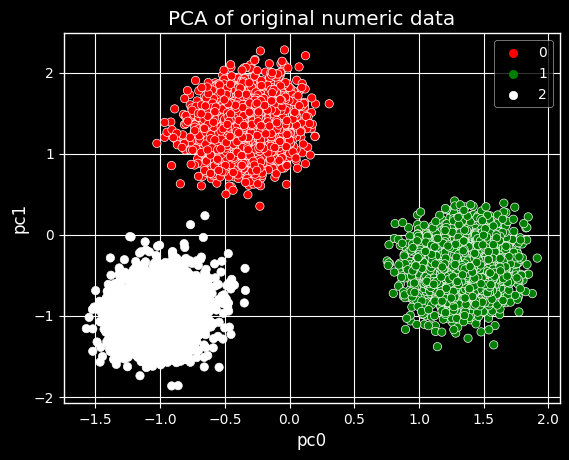

In [29]:
# 8.1 2D PCA plot from original train data:

plt.style.use("dark_background")
sns.scatterplot(data = orig_pca ,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["red", "green", "white"]
                ).set(title='PCA of original numeric data');


In [30]:
# 3D PCA original data:
#  (plotly graphs do not show on github)

pca = PCA(n_components = 3,  whiten= True, random_state= None)
ss= StandardScaler()
orig_pca = pca.fit_transform(ss.fit_transform(orig_train[cat_cols]))


fig = px.scatter_3d(
    orig_pca, x=0, y=1, z=2, color=ytr.values,
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

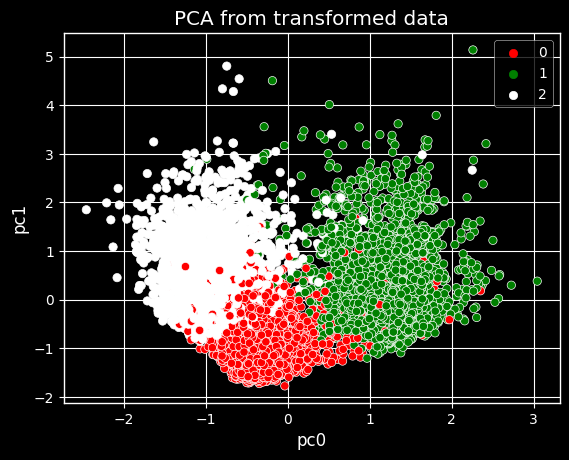

In [31]:
# 8.2 2D PCA plot from transformed data:

plt.style.use("dark_background")
sns.scatterplot(data = trans_pca,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["red", "green", "white"]
                ).set(title='PCA from transformed data') ;

In [32]:
# 3D plot of transformed data:

trans_pca = train_trans.iloc[:,len(cat_cols):]   # Drop the six binned columns
pca = PCA(n_components= 3, whiten= True, random_state = None)
ss = StandardScaler()
trans_pca = pca.fit_transform(ss.fit_transform(trans_pca))
colnames = ["pc" + str(i) for i in range(orig_pca.shape[1])]
trans_pca = pd.DataFrame(trans_pca, columns = colnames)

In [34]:
fig = px.scatter_3d(
                     trans_pca, x='pc0', y='pc1', z='pc2', color=ytr.values,
                    )
fig.show()

# Plotly plots do not show up when published on github

## xgboost modeling of original data and of transformed data:

In [35]:
# 9.0 Original train/test data:

model_orig = xgb.XGBClassifier( n_estimators= 50,
                               verbosity = 3,
                               eta = 0.06,      
                               max_depth = 6,
                               subsample = 0.8, 
                               random_state = None,
                              )


tr_X =   orig_train
test_X = orig_test
ytr = ytr 
yte = yte 


model_orig.fit(tr_X, ytr.values,             
               early_stopping_rounds = 10,   
               eval_set=[ (tr_X, ytr.values), (test_X, yte.values)], 
               eval_metric = ['auc']        
              )



[10:31:36] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[10:31:36] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[10:31:36] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[10:31:36] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[0]	validation_0-auc:1.00000	validation_1-auc:1.00000
[10:31:36] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[10:31:36] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[10:31:36] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[1]	validation_0-auc:1.00000	validation_1-auc:1.00000
[10:31:36] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[10:31:36] INFO: ../src/tree/updater_prune.cc:9

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [36]:
# 9.1 Scores:

f"Best auc from orig train/test data: {model_orig.best_score}"
print("\n===========\n")
f"Best iteration from orig train/test data: {model_orig.best_iteration}"

'Best auc from orig train/test data: 1.0'

'Best iteration from orig train/test data: 0'

In [87]:
# 9.2 Modeling with transformed train/test data:

model_trans = xgb.XGBClassifier( n_estimators= 50,
                           verbosity = 3,
                           eta = 0.06,      
                           max_depth = 14,
                           subsample = 0.8,        
                           random_state = None,
                           )


tr_X =   train_trans.iloc[:,len(cat_cols):]
test_X = test_trans.iloc[:,len(cat_cols):]
ytr = ytr 
yte = yte 


model_trans.fit(tr_X, ytr.values,     
          early_stopping_rounds = 10, 
          eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
          eval_metric = ['auc']    
          )



[10:50:52] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[10:50:53] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=9
[10:50:53] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[10:50:54] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[0]	validation_0-auc:1.00000	validation_1-auc:1.00000
[10:50:54] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=12
[10:50:54] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[10:50:54] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation_0-auc:1.00000	validation_1-auc:1.00000
[10:50:55] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=9
[10:50:55] INFO: ../src/tree/updater_prune.cc

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

### Learning curve plots

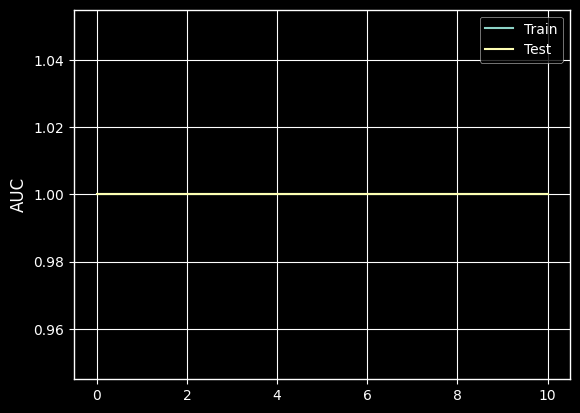

In [38]:
# 9.3 Modeling with original data:

# Ref: https://stackoverflow.com/a/60366515
results = model_orig.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
fig, ax = plt.subplots();
ax.plot(x_axis, np.round(results['validation_0']['auc'],2), label='Train');
ax.plot(x_axis, np.round(results['validation_1']['auc'],2), label='Test');
ax.legend();
plt.ylabel('AUC');
#plt.title('XGBoost AUC__Original data');
plt.show();

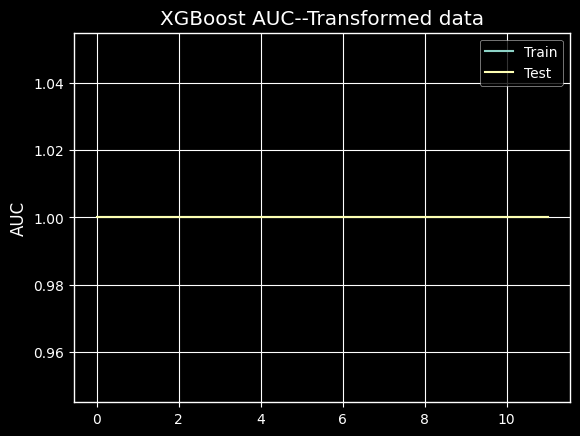

In [39]:
# 9.4 Modeling with transformed data:

results = model_trans.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
fig, ax = plt.subplots();
ax.plot(x_axis, np.round(results['validation_0']['auc'],2), label='Train');
ax.plot(x_axis, np.round(results['validation_1']['auc'],2), label='Test');
ax.legend();
plt.ylabel('AUC');
plt.title('XGBoost AUC--Transformed data');
plt.show();

In [40]:
# 9.5
f"Best auc from transformed train/test data: {model_trans.best_score}"
print("\n===========\n")
f"Best iteration from transformed train/test data: {model_trans.best_iteration}"

'Best auc from transformed train/test data: 1.0'

'Best iteration from transformed train/test data: 1'

## Feature importance from transformed features
Extract feature importance using function `utils.xgImptFeatures()`. The function outputs three objects as follows::  
>`fe_1`: List of columns arranged in order of descending xgboost impt(feat-impt >0)<br>
>`fe_0`: List of columns whose xgboost importance is zero<br>
>`fe`: One-column dataframe of feature importance(top-down). Col name is 'imp'<br>  

In [88]:
# 10.0 Get feature importance:
#      fe: Sorted Pandas DataFrame with column name and top-down feature impt 

fe_1, fe_0, fe = utils.xgImptFeatures(model_trans,  train_trans.iloc[:,len(cat_cols):].columns)
print("\n=== DataFrame  of impt features top-down =======\n")
fe.iloc[:5]
print("\n\n== Column-list whose feat impt >0 =======\n")
fe_1[:5]     # Arranged in descending order of impt
print("\n\n===Column-list whose feat impt is 0 =======\n")
fe_0[:5]


Order of feature importance is by 'gain'

=== DataFrame  of impt features top-down =======



,imp
clu_d_ck_a_p_b,0.341338
eig_e_ck_b,0.264856
eig_c_ck_b_p_d,0.195119
bet_d_ck_a_p_b,0.070293
eig_b_ck_f,0.048206




== Column-list whose feat impt >0 =======



['clu_d_ck_a_p_b',
 'eig_e_ck_b',
 'eig_c_ck_b_p_d',
 'bet_d_ck_a_p_b',
 'eig_b_ck_f']



===Column-list whose feat impt is 0 =======



['bet_c_ck_a_p_f',
 'pr_c_ck_d_p_e',
 'deg_b_ck_a_p_d',
 'eig_c_ck_a_p_f',
 'deg_c_ck_d_p_e']

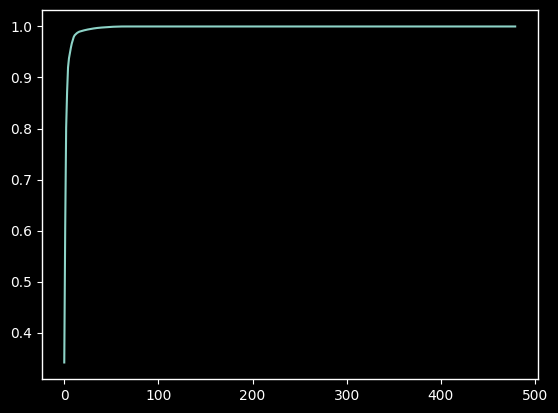

In [89]:
# 10.1 Cumulative sum of feature importance.
#      Last 100 columns have zero or (near zero)
#      importance:

plt.plot(range(len(fe)), fe['imp'].cumsum().values);
plt.grid();

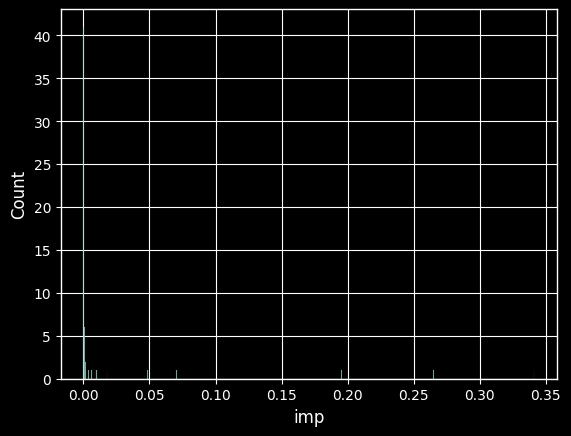

In [90]:
# 10.2 A histogram plot of feature importance score
#      Most columns have feature impt below 0.01

sns.histplot(fe['imp'][fe_1]);

## PCA plot of trasnformed data but with impt features
This plot is better than the earlier one

### xgboost of transformed data with impt features only:
Does it impact auc? AUC is till 1.0

In [50]:
# 11.0 How many?
len(fe_1)
print("\n=====\n")
# 11.1 Which ones?
print(fe_1)

64

['clu_d_ck_a_p_b', 'eig_e_ck_b', 'eig_c_ck_b_p_d', 'bet_d_ck_a_p_b', 'eig_b_ck_f', 'eig_b_ck_a_p_c', 'deg_b_ck_e', 'eig_d_ck_d_p_f', 'clu_b_ck_c_p_f', 'clu_f_ck_c_p_d', 'pr_b_ck_a', 'pr_c_ck_b', 'clu_c_ck_b', 'deg_c_ck_a', 'deg_c_ck_b', 'pr_c_ck_a', 'eig_f_ck_e_p_f', 'eig_f_ck_b', 'eig_b_ck_a', 'deg_b_ck_f', 'pr_f_ck_b_p_c', 'clu_c_ck_b_p_d', 'eig_a_ck_b_p_c', 'deg_f_ck_b', 'deg_a_ck_c', 'pr_a_ck_b_p_e', 'pr_d_ck_b', 'eig_c_ck_c_p_f', 'pr_a_ck_d', 'deg_f_ck_b_p_d', 'eig_a_ck_b_p_e', 'deg_b_ck_c', 'eig_a_ck_a_p_d', 'eig_c_ck_d_p_e', 'eig_b_ck_d', 'eig_c_ck_b_p_c', 'eig_e_ck_a_p_b', 'deg_f_ck_a_p_c', 'deg_d_ck_b_p_f', 'deg_d_ck_c', 'clu_b_ck_a_p_f', 'eig_a_ck_a_p_b', 'eig_a_ck_a_p_f', 'pr_b_ck_f', 'pr_b_ck_d', 'deg_a_ck_b', 'clu_e_ck_d_p_f', 'clu_f_ck_b', 'pr_f_ck_d', 'deg_c_ck_d', 'clu_c_ck_f', 'deg_f_ck_b_p_c', 'eig_d_ck_a_p_d', 'eig_c_ck_c_p_e', 'deg_a_ck_e', 'eig_e_ck_b_p_e', 'deg_c_ck_b_p_d', 'deg_f_ck_a', 'pr_c_ck_a_p_b', 'eig_e_ck_c_p_e', 'eig_a_ck_d', 'eig_a_ck_a_p_e', 'pr_c_ck_a

In [98]:
# 11.2 Modeling with transformed train/test data with impt features:

# Lest we repeat the process many times:
# Del the earlier result:

if 'model_trans_impt' in globals():
    del model_trans_impt

model_trans_impt = xgb.XGBClassifier( n_estimators= 50,
                           verbosity = 3,
                           eta = 0.06,      
                           max_depth = 14,
                           subsample = 0.8,        
                           random_state = None,
                           )


tr_X =   train_trans[fe_1[:10]]
test_X = test_trans[fe_1[:10]]
ytr = ytr 
yte = yte 


model_trans_impt.fit(tr_X, ytr.values,     
          early_stopping_rounds = 5, 
          eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
          eval_metric = ['auc']    
          )



[10:55:52] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[10:55:52] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[10:55:52] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[10:55:52] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[0]	validation_0-auc:1.00000	validation_1-auc:1.00000
[10:55:52] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[10:55:52] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[10:55:52] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[1]	validation_0-auc:1.00000	validation_1-auc:1.00000
[10:55:52] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[10:55:52] INFO: ../src/tree/updater_prune.cc:9

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

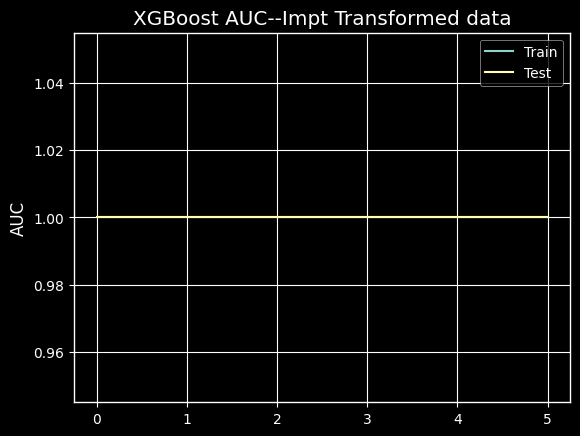

In [99]:
# 9.4 Modeling with transformed data:

results = model_trans_impt.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
fig, ax = plt.subplots();
ax.plot(x_axis, np.round(results['validation_0']['auc'],2), label='Train');
ax.plot(x_axis, np.round(results['validation_1']['auc'],2), label='Test');
ax.legend();
plt.ylabel('AUC');
plt.title('XGBoost AUC--Impt Transformed data');
plt.show();

### And now PCA of transformd data with impt features:
Much clearer and cleaner plot

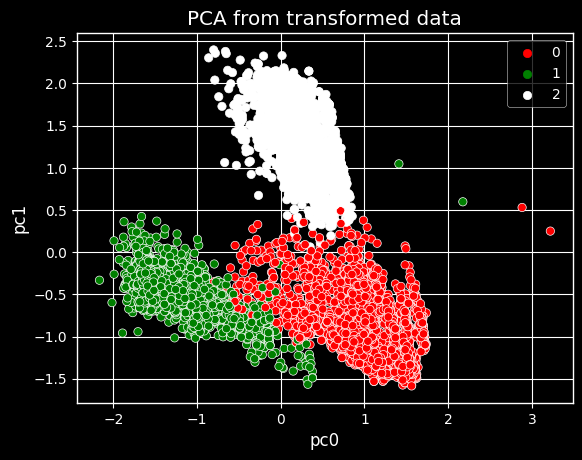

In [100]:
# 11.2 2D PCA with transformed train data.
#       Only with impt features:

trans_pca = train_trans[fe_1[:10]]   # Drop the six binned columns
pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
trans_pca = pca.fit_transform(ss.fit_transform(trans_pca))
trans_pca.shape

# Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(trans_pca.shape[1])]
trans_pca = pd.DataFrame(trans_pca, columns = colnames)

# PCA plot from impt transformed data:

plt.style.use("dark_background")
sns.scatterplot(data = trans_pca,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["red", "green", "white"]
                ).set(title='PCA from transformed data') ;

In [101]:
# 11.3 3D plot of transformed data:
#       Plot does not show on github

trans_pca = train_trans[fe_1[:10]]
pca = PCA(n_components= 3, whiten= True, random_state = None)
ss = StandardScaler()
trans_pca = pca.fit_transform(ss.fit_transform(trans_pca))
colnames = ["pc" + str(i) for i in range(orig_pca.shape[1])]
trans_pca = pd.DataFrame(trans_pca, columns = colnames)
fig = px.scatter_3d(
                     trans_pca, x='pc0', y='pc1', z='pc2', color=ytr.values,
                    )
fig.show()

# Note: Plotly plots do not appear when published on github

## Correlation of transformed data with orig columns
Correlation of extracted features with original features

In [102]:
# 12.0 Take all the four imp features:

tt = train_trans[fe_1[:5]].copy()
tt.shape  # (9000,4)

(9000, 5)

In [103]:
# 12.1 Reindex orig_train and merge with 'tt':

ot= orig_train.reset_index(drop = True).copy()
result = ot.merge(tt, left_index = True, right_index=True )


Correlation heatmap shows good amount of correlation between the two sets of features

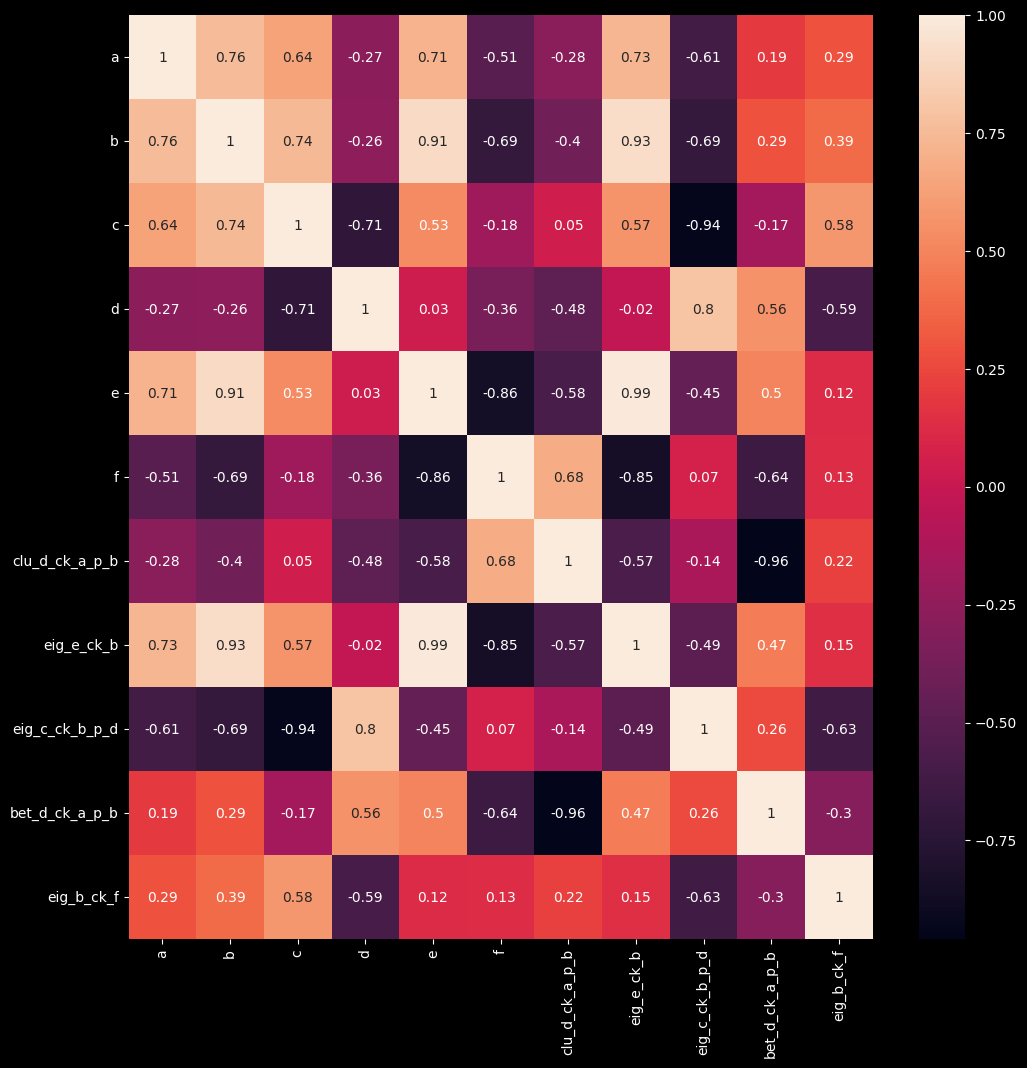

In [104]:
# 12.2 Correlation heatmap:

plt.figure(figsize = (12,12))
sns.heatmap(np.round(result.corr(),2), annot = True);

## Distribution of columns
Distribution of columns related to different centrality measures

### Proportion of columns by centrality measure:

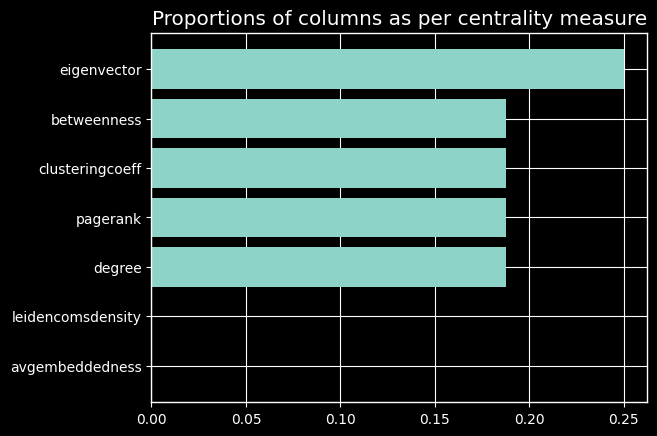

In [69]:
# 13.0 Our list of columns

colList = (train_trans.iloc[:,len(cat_cols):]).columns

# Count of columns by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(colList, normalize = True)
utils.plotSeries(f, "Proportions of columns as per centrality measure")

### Proportions of columns by centrality whose impt is > 0

In [70]:
# 13.1 Extract column importance:

fe_1, fe_0,_ = utils.xgImptFeatures(model_trans, colList)
f"Columns whose impt is >0: {len(fe_1)}"
print("\n")
f"Columns whose impt is 0: {len(fe_0)}"


Order of feature importance is by 'gain'


'Columns whose impt is >0: 10'

'Columns whose impt is 0: 0'

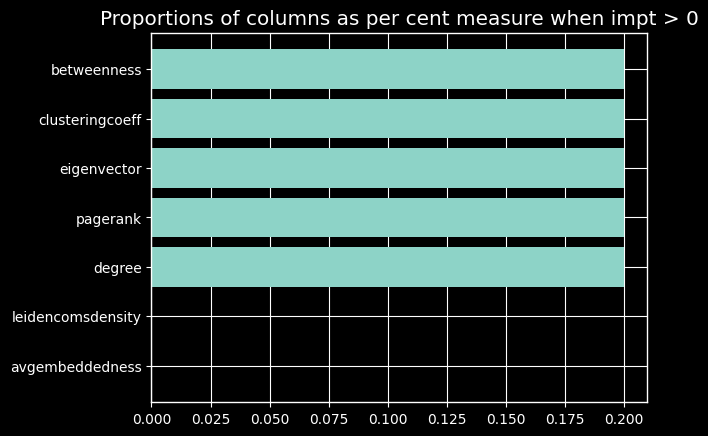

In [71]:
# 13.2 Count of columns whose xgboost impt > 0 by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(fe_1, normalize = True)
utils.plotSeries(f, "Proportions of columns as per cent measure when impt > 0")

### Proportions of columns by summed-up importance score of each centrality measure

In [73]:
# 14.0 Extract xgboost feature importance:
fe_1, _, fe = utils.xgImptFeatures(model_trans, colList)



Order of feature importance is by 'gain'


In [74]:
# 14.1 Column-wise importance score (whose impt > 0)
#      score is a Pandas Series
score = fe['imp'][fe_1]

# 14.2 Score of all impt columns:
score

deg_a_ck_b    0.442162
eig_a_ck_b    0.332609
pr_a_ck_b     0.144483
bet_a_ck_b    0.032051
deg_a_ck_c    0.019315
clu_a_ck_c    0.014040
pr_a_ck_c     0.013283
bet_a_ck_c    0.001194
clu_a_ck_b    0.000474
eig_a_ck_c    0.000390
Name: imp, dtype: float32

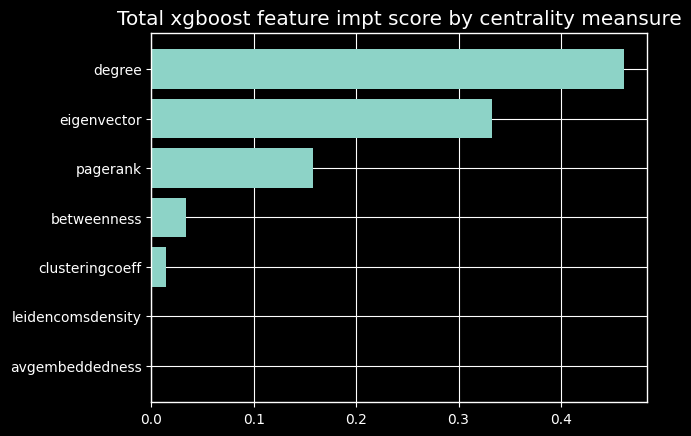

In [75]:
# 14.3 Extract and plot total xgboost impt scores by centrality measure:

g = utils.featureImptByScore(score, fe_1, True)
utils.plotSeries(g, "Total xgboost feature impt score by centrality meansure")

## Mutual information

In [ ]:
from sklearn.feature_selection import mutual_info_classif



In [ ]:
mi_scores = utils.calMIScores(train_trans[colList], ytr)
mi_scores[::3]  # show a few features with their MI scores

eig_area_mean_ck_concavity_worst_p_concavity_mean       0.411510
eig_area_mean_ck_area_mean_p_area_se                    0.398181
eig_area_mean_ck_area_mean_p_texture_mean               0.396951
eig_area_mean_ck_area_se_p_concavity_worst              0.388818
eig_area_mean_ck_area_mean_p_concavity_worst            0.386731
                                                          ...   
deg_texture_mean_ck_concavity_worst_p_concavity_mean    0.048080
eig_area_se_ck_concavity_worst                          0.043185
deg_texture_mean_ck_area_mean_p_concavity_worst         0.032534
bet_texture_mean_ck_area_se                             0.011870
pr_texture_mean_ck_area_se                              0.000000
Name: MI Scores, Length: 90, dtype: float64

In [ ]:
fe.cumsum()
len(fe)